## This notebook check the hexapod state transitions and move/offset commands
## It also checks the LUT against the input polynomials, before and after a slew

This notebook works with both hexapods.

To switch between the hexapods, change the cell below.

In [1]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import ATPtg
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst_efd_client import EfdClient

In [2]:
hexIdx = 1 #camera hexapod
#hexIdx = 2 #M2 hexapod

In [3]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-shmem.xml


In [4]:
start_time = datetime.now()
script = salobj.Controller("Script", index=42658887)

#wait 10 second may help with DDS problems; closing all other kernels may help too
#This is to avoid a race condition between when the domain register the master and the readers are registered.
#await asyncio.sleep(25) 

In [5]:
#Only needed wht doing a test with the telescope slewing
#ptg = salobj.Remote(script.domain, "MTPtg")

In [6]:
 hex = salobj.Remote(script.domain, "MTHexapod", index=hexIdx) #1 for camera hexapod and 2 for m2 hexapod

electrical DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 25 of 100 elements
electrical DDS read queue is filling: 26 of 100 elements
electrical DDS read queue is filling: 24 of 100 elements
electrical DDS read queue is filling: 12 of 100 elements
electrical DDS read queue is filling: 50 of 100 elements
electrical DDS read queue is filling: 33 of 100 elements
electrical DDS read queue is filling: 13 of 100 elements
electrical DDS read queue is filling: 15 of 100 elements
electrical DDS read queue is filling: 64 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 13 of 100 elements
electrical DDS read queue is filling: 12 of 100 elements
electrical DDS read queue is filling: 50 of 100 elements
electrical DDS read queue is filling: 24 of 100 

In [7]:
#mount = salobj.Remote(script.domain, "MTMount")

In [8]:
#Start a controller instead of the Mount simulator
#mount = salobj.Controller(name="MTMount", index=0)

In [9]:
rot = salobj.Remote(script.domain, "MTRotator")
print(f'time to start is {datetime.now() - start_time} [s]')

time to start is 0:00:34.135908 [s]


In [10]:
await asyncio.gather(#ptg.start_task,#mount.start_task,
                     script.start_task, #                     
                     rot.start_task,
                     hex.start_task)

[None, None, None]

In [11]:
#This only works on domain 0
#await ptg.start_task

In [12]:
#As long as you get something its OK. we dont' care about h.heartbeat
await hex.evt_heartbeat.next(flush=True, timeout=5)

In [13]:
#This only works on domain 0
#await ptg.evt_heartbeat.next(flush=True, timeout=5)

In [14]:
await rot.evt_heartbeat.next(flush=True, timeout=5)

In [15]:
#Check some configurations
hexConfig = await hex.evt_configuration.aget(timeout=10.)
print("pivot at (%.0f, %.0f, %.0f) microns "%(hexConfig.pivotX, hexConfig.pivotY, hexConfig.pivotZ))
print("maxXY = ", hexConfig.maxXY, "microns, maxZ= ", hexConfig.maxZ, " microns")
print("maxUV = ", hexConfig.maxUV, "deg, maxW= ", hexConfig.maxW, " deg")

pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg


### test state transition. If hex is already enabled, disable then enable it.

In [16]:
state = await hex.evt_summaryState.aget(timeout=5)
print('staring with: hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
if state.summaryState == 2:
    await salobj.set_summary_state(hex, salobj.State.DISABLED) #disable hex

staring with: hex state State.ENABLED 2021-04-26 16:39:00.682660608


In [17]:
await salobj.set_summary_state(remote=hex, state=salobj.State.STANDBY)


[<State.DISABLED: 1>, <State.STANDBY: 5>]

In [18]:
await salobj.set_summary_state(remote=hex, state=salobj.State.DISABLED)

RuntimeError: Error on cmd=cmd_start, initial_state=5: msg='Command failed', ackcmd=(ackcmd private_seqNum=2014067662, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Failed: final state is <State.STANDBY: 5> instead of <State.DISABLED: 1>')

In [22]:
await salobj.set_summary_state(hex, salobj.State.ENABLED, settingsToApply="default") #enable hex

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [17]:
client = EfdClient('summit_efd')

In [18]:
# the next line only work if information were sent to the EFD during the time spann "timedelta"!
csc_index = 1
end = Time(datetime.now(), scale='tai')
start = end - timedelta(hours=6)
while True: #may need to wait a few seconds before event shows up in EFD
    dfe = await client.select_time_series('lsst.sal.MTHexapod.logevent_summaryState', '*', start, end, csc_index)
    #dfe = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end)
    if len(dfe)>0:
        break
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
#we cannot get time series data from DDS. We have to query the EFD

In [19]:
dfe

,MTHexapodID,priority,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-04-26 16:37:14.386000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,15,1.619455e+09,1
2021-04-26 16:37:14.476000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,16,1.619455e+09,5
2021-04-26 16:37:14.706000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,17,1.619455e+09,1
2021-04-26 16:38:20.314000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,18,1.619455e+09,5
2021-04-26 16:39:00.642000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,19,1.619455e+09,1
2021-04-26 16:39:00.682000+00:00,1,0,0,MTHexapod:1,1.619455e+09,3413,1.619455e+09,959a0a03,20,1.619455e+09,2


### check the behavior when LUT is disabled.

In [21]:
lutMode = await hex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? False


In [27]:
async def printPosition(hex):
    pos = await hex.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position))
await printPosition(hex)

Current Hexapod position
     -0.29      -0.48      -0.27      -0.00       0.00      -0.00


In [24]:
test_message = "Camera Hexapod Integration Test"

In [25]:
#This command is to set the Hexapod to zero position
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 -- Move to Zero- Starting time: {now} UTC")
await hex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [81]:
#To stop the Hexapod
await hex.cmd_stop.set_start()

If you want to observe the motions in chronograf, consider using "AND MTHexapodID={hexId}" to filter out telemetry from the other hexapod

In [34]:
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 Compensation mode test Step 17- Starting time: {now} UTC")
hex.evt_inPosition.flush()
for step in range(5,-1,-1):
    #await hex.cmd_move.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    #Steps made smaller make sure to not go into fault
    await hex.cmd_move.set_start(x=0,y=0,z=-50*step, u=0,v=0,w=0,sync=True)
    # InPosition event is not generated at the moment
    while True:
        state = await hex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break    

hex in position? False 2021-04-23 21:40:02.096637184
hex in position? True 2021-04-23 21:40:04.038309376
hex in position? False 2021-04-23 21:40:04.307934976
hex in position? True 2021-04-23 21:40:05.559797760
hex in position? False 2021-04-23 21:40:05.791507712
hex in position? True 2021-04-23 21:40:07.051962880
hex in position? False 2021-04-23 21:40:07.272422656
hex in position? True 2021-04-23 21:40:08.533875968
hex in position? False 2021-04-23 21:40:08.804473856
hex in position? True 2021-04-23 21:40:10.065470720
hex in position? False 2021-04-23 21:40:10.335844864
hex in position? True 2021-04-23 21:40:11.547326208


In [33]:
await printPosition(hex)

Current Hexapod position
      0.11       0.17       0.43       0.00      -0.00       0.00


In [66]:
hex.evt_inPosition.flush()
for step in [1,2,3,-3,-2,-1]:
    #according to XML, units are micron and degree
    #await hex.cmd_offset.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    #Steps made smaller make sure to not go into fault
    await hex.cmd_move.set_start(x=0,y=0,z=-50*step, u=0,v=0,w=0,sync=True)
    # InPosition event is not generated at the moment
    while True:
        state = await hex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
     
    await printPosition(hex)
    
    end = Time(datetime.now(), scale='tai')

hex in position? False 2021-04-23 21:59:57.487185920
hex in position? True 2021-04-23 21:59:58.929353472
Current Hexapod position
     -0.26      -0.12     -50.27      -0.00       0.00      -0.00
hex in position? False 2021-04-23 21:59:59.239366656
hex in position? True 2021-04-23 22:00:00.499813632
Current Hexapod position
     -0.26      -0.27    -100.27      -0.00       0.00      -0.00
hex in position? False 2021-04-23 22:00:00.770716928
hex in position? True 2021-04-23 22:00:02.031922944
Current Hexapod position
     -0.45      -0.28    -150.24      -0.00       0.00      -0.00
hex in position? False 2021-04-23 22:00:02.342935040
hex in position? True 2021-04-23 22:00:04.374896896
Current Hexapod position
      0.39      -0.04     150.32      -0.00      -0.00      -0.00
hex in position? False 2021-04-23 22:00:04.685085440
hex in position? True 2021-04-23 22:00:05.946911488
Current Hexapod position
     -0.40      -0.37      99.74      -0.00       0.00       0.00
hex in position? Fal

In [69]:
start = end - timedelta(seconds=120)
df = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)
idx=df.MTHexapodID==1
df = df[idx]

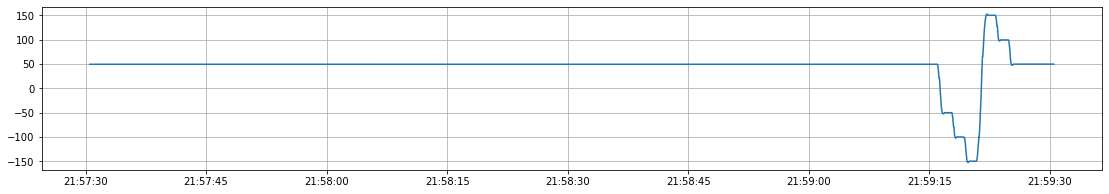

In [70]:
fig, ax = plt.subplots(figsize=(19,3))
plt.plot(df.position2)
plt.grid()

### When the LUT is enabled

In [61]:
await hex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
lutMode = await hex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? True


In [82]:
#Switch compensation mode off:
await hex.cmd_setCompensationMode.set_start(enable=0, timeout=10)
lutMode = await hex.evt_compensationMode.aget(timeout=10)
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? False


In [75]:
await printPosition(hex)

Current Hexapod position
     -0.36      -0.45      49.68      -0.00       0.00      -0.00


In [74]:
async def printUncompensatedAndCompensated(hex):
    posU = await hex.evt_uncompensatedPosition.aget(timeout=10.)
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyzuvw']))
    print(pd.to_datetime(posU.private_sndStamp, unit='s'))
    posC = await hex.evt_compensatedPosition.aget(timeout=10.)
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyzuvw']))
    print(pd.to_datetime(posC.private_sndStamp, unit='s'))

await printUncompensatedAndCompensated(hex)

Uncompensated position
      0.00       0.00      50.00       0.00       0.00       0.00
2021-04-23 22:00:06.078814976
Compensated position
      0.00       0.00      50.00       0.00       0.00       0.00
2021-04-23 22:00:06.079221760


The inputs to the LUT are currently -
* elevation (from mount telemetry) 
* temperature (mount truss? not implemented yet)
* azimuth (not implemented)
* rotator angle (not implemented)

In [42]:
#Mount needs to be prepared
#await salobj.set_summary_state(mount, salobj.State.ENABLED)

In [43]:
#Only works when mount or mount simulator are active.Best on domain 1
#mountAngle = await mount.tel_elevation.aget(timeout=10.)
#print("mount elevation angle", mountAngle.angleActual)
#elev = mountAngle.angleActual

In [ ]:
#To set the elevation for a controller
#mount.evt_target.set_put(elevation=45)

In [71]:
end = Time(datetime.now())
start = end - timedelta(hours=3)
#logeventTarget = await client.select_time_series('lsst.sal.MTMount.logevent_target', '*', start.tai, end.tai)
#With this we can get the elevation when a controller is running
MTMountElevation = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start.tai, end.tai)
MTMountAzimuth = await client.select_time_series('lsst.sal.MTMount.azimuth', '*', start.tai, end.tai)

In [72]:
#get the elevation into a variable
elev=MTMountElevation.actualPosition
print("Mount controller elevation from the EFD:")
elev

Mount controller elevation from the EFD:


2021-04-23 21:03:58.517000+00:00    89.5
2021-04-23 21:03:59.522000+00:00    89.5
2021-04-23 21:04:00.527000+00:00    89.5
2021-04-23 21:04:01.532000+00:00    89.5
2021-04-23 21:04:02.537000+00:00    89.5
                                    ... 
2021-04-23 22:00:39.620000+00:00    80.0
2021-04-23 22:00:39.821000+00:00    80.0
2021-04-23 22:00:40.022000+00:00    80.0
2021-04-23 22:00:40.223000+00:00    80.0
2021-04-23 22:00:40.425000+00:00    80.0
Name: actualPosition, Length: 8925, dtype: float64

In [73]:
azimuth = MTMountAzimuth.actualPosition
print("Mount controller azimuth from the EFD:")
azimuth

Mount controller azimuth from the EFD:


2021-04-23 21:03:58.518000+00:00    45
2021-04-23 21:03:59.523000+00:00    45
2021-04-23 21:04:00.528000+00:00    45
2021-04-23 21:04:01.533000+00:00    45
2021-04-23 21:04:02.538000+00:00    45
                                    ..
2021-04-23 22:00:39.619000+00:00     0
2021-04-23 22:00:39.820000+00:00     0
2021-04-23 22:00:40.021000+00:00     0
2021-04-23 22:00:40.222000+00:00     0
2021-04-23 22:00:40.424000+00:00     0
Name: actualPosition, Length: 8925, dtype: int64

In [76]:
elevationFixed=80.0

In [77]:
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
if hex.salinfo.index == 1:
    elevCoeff = aa['camera_config']['elevation_coeffs']
    tCoeff = aa['camera_config']['temperature_coeffs']
elif hex.salinfo.index == 2:
    elevCoeff = aa['m2_config']['elevation_coeffs']
    tCoeff = aa['m2_config']['temperature_coeffs']

In [78]:
async def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        #mypoly = np.poly1d(coeff[::-1]) #if you use poly1d, be aware: it needs C5 first
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))
await printPredictedComp(elevCoeff, elevationFixed)
await printUncompensatedAndCompensated(hex)

Predicted LUT compensation:
     -0.87    -423.42     283.37      -0.01       0.00       0.00
Uncompensated position
      0.00       0.00      50.00       0.00       0.00       0.00
2021-04-23 22:00:06.078814976
Compensated position
      0.00       0.00      50.00       0.00       0.00       0.00
2021-04-23 22:00:06.079221760


### Do a slew, then check the LUT again

In [ ]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)
print("Current elevation angle = ", elev)

In [ ]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 80. * u.deg
az = 0. * u.deg
rot_tel = Angle(0, unit= u.deg) 

In [ ]:
target_name="TMA motion test"
time_data = await ptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_ptg = Time(time_data.mjd, format="mjd", scale="tai")
time_err = curr_time_ptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

print(curr_time_ptg.tai.value)

cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_ptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)
# Calculating the other parameters     
rot_pa = rot_tel

In [ ]:
#The pointing component is commanding the mount directly
await ptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=ATPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    rotPA=rot_pa.deg-180,
    rotFrame=ATPtg.RotFrame.FIXED,
    rotMode=ATPtg.RotMode.FIELD,
    timeout=10
)

print(" Now, Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

### check angle and LUT after the slew

In [ ]:
mountAngle = await mount.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.angleActual)
elev = mountAngle.angleActual

In [ ]:
await printPosition(hex)
await printUncompensatedAndCompensated(hex)
await printPredictedComp(elevCoeff, elev)

### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [ ]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

In [ ]:
#Stop the MTMount controller
await mount.close()